# Stage 2b: Generate AI Alpha Factors

- Compute target values (y)
    - Quantize with 2 bins for testing
    - Quantize with 25 bins for production
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

In [83]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

# Price History data from Stage 1

In [3]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks')
print(pricing.columns.to_list())
pricing.tail()

Date range for price histories: 2018-07-09 to 2021-07-09
You have 526 stocks
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEI', 'AEP', 'AES', 'AFL', 'AIG', 'AIH', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAN', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COKE', 'CONN', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,ZKIN
date,,,,,,,,,,,,,,,,,,,,,
2021-07-02 00:00:00+00:00,148.82,21.48,211.05,139.96,115.17,116.62,317.02,118.04,304.84,593.07,...,365.74,23.26,34.31,121.50,66.82,144.56,63.17,63.89,120.89,3.9500
2021-07-06 00:00:00+00:00,148.98,21.01,208.70,142.02,115.73,115.42,326.71,118.82,305.40,596.90,...,368.99,22.96,33.97,116.90,67.07,144.17,61.37,63.09,120.46,3.9300
2021-07-07 00:00:00+00:00,149.49,20.31,209.44,144.57,116.75,115.04,334.53,119.87,309.61,605.77,...,372.66,23.23,34.84,112.91,67.69,137.44,60.41,63.63,120.67,3.6200
2021-07-08 00:00:00+00:00,148.83,20.35,207.51,143.24,116.35,114.44,325.04,119.26,309.15,605.95,...,373.11,22.94,35.04,111.66,67.50,133.77,60.14,61.91,119.19,3.6600
2021-07-09 00:00:00+00:00,150.03,20.89,213.47,145.11,116.58,115.13,324.77,119.74,312.62,604.50,...,374.19,23.31,35.82,113.87,67.67,135.59,61.23,62.42,121.05,3.7181


## Read existing factors

In [56]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
print(f'Stocks: {all_assets}')
all_factors.sort_values(['ticker', 'date']).tail(10)

Factors from date: 2019-07-10 00:00:00+00:00 to date: 2021-07-09 00:00:00+00:00
Stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEI', 'AEP', 'AES', 'AFL', 'AIG', 'AIH', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAN', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COKE', 'CONN', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA

,,momentum_252_day_logret,mean_reversion_5_day_logret_smoothed,overnight_sentiment_5_day_smoothed,annualzed_volatility_20_day,annualzed_volatility_120_day,average_dollar_volume_20_day,average_dollar_volume_120_day,market_dispersion20_day,market_dispersion120_day,market_volatility20_day,market_volatility120_day,is_January,is_December,weekday,quarter,year,month_start,month_end,quarter_start,quarter_end
date,ticker,,,,,,,,,,,,,,,,,,,,
2021-06-25 00:00:00+00:00,ZKIN,1.629975,0.563082,1.649732,1.616803,1.676075,-1.709004,-1.629975,0.023172,0.024589,0.081948,0.113910,0,0,4,2,2021,0,0,0,0
2021-06-28 00:00:00+00:00,ZKIN,1.629975,0.826512,1.656318,1.590460,1.676075,-1.709004,-1.629975,0.022244,0.024573,0.084209,0.113035,0,0,0,2,2021,0,0,0,0
2021-06-29 00:00:00+00:00,ZKIN,1.629975,1.096528,1.656318,1.603632,1.676075,-1.702418,-1.629975,0.020567,0.024428,0.079374,0.110563,0,0,1,2,2021,0,0,0,0
2021-06-30 00:00:00+00:00,ZKIN,1.629975,1.300687,1.597046,1.544360,1.676075,-1.702418,-1.629975,0.020119,0.024365,0.080268,0.109412,0,0,2,2,2021,0,1,0,1
2021-07-01 00:00:00+00:00,ZKIN,1.643146,1.221658,1.267758,1.531188,1.682661,-1.702418,-1.629975,0.019455,0.024342,0.082924,0.109696,0,0,3,3,2021,1,0,1,0
2021-07-02 00:00:00+00:00,ZKIN,1.636560,1.392887,0.991156,1.537774,1.682661,-1.702418,-1.629975,0.018903,0.024271,0.079476,0.109587,0,0,4,3,2021,0,0,0,0
2021-07-06 00:00:00+00:00,ZKIN,1.643146,1.550946,1.221658,1.557531,1.682661,-1.702418,-1.629975,0.018505,0.024235,0.085545,0.109971,0,0,1,3,2021,0,0,0,0
2021-07-07 00:00:00+00:00,ZKIN,1.616803,1.518017,0.833098,1.570703,1.682661,-1.702418,-1.629975,0.018571,0.024244,0.085392,0.109705,0,0,2,3,2021,0,0,0,0
2021-07-08 00:00:00+00:00,ZKIN,1.629975,1.656318,0.306238,1.590460,1.682661,-1.709004,-1.629975,0.018488,0.024193,0.090817,0.110835,0,0,3,3,2021,0,0,0,0


## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [57]:
target_source = '5Day2Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 2, 5).for_al(target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[target_source].shift(-forward_prediciton_days)
all_factors[[target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.549913   
                          AAL                   -1.103119   
                          AAP                    0.227210   
                          AAPL                   0.009879   
                          ABBV                  -1.366551   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-10 00:00:00+00:00 A                                  -1.346793   
                          AAL                                -0.694800   
                          AAP                                 0.418197   
                          AAPL                               -1.057019   
                          ABBV                                1.379722   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-10 00:00:00+00:00 A                                 0.233794   
                          AAL                               0.767241   
                          AAP                              -0.602597   
                          AAPL                             -0.075736   
                          ABBV                             -0.628940   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-10 00:00:00+00:00 A                          0.866031   
                          AAL                        1.122877   
                          AAP                        0.411612   
                          AAPL                       0.734315   
                          ABBV                       0.905546   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.714558   
                          AAL                         0.457712   
                          AAP                        -0.754073   
                          AAPL                        1.406065   
                          ABBV                       -1.089948   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.075737   
                          AAL                         0.431369   
                          AAP                         0.075737   
                          AAPL                        1.722183   
                          ABBV                        1.603639   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-10 00:00:00+00:00 A                            0.082322   
                          AAL                          0.576256   
                          AAP                          0.332582   
                          AAPL                         1.722183   
                          ABBV                         1.399480   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.013883   
                          AAL                    0.013883   
                          AAP                    0.013883   
                          AAPL                   0.013883   
                          ABBV                   0.013883   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-10 00:00:00+00:00 A                       0.016321   
                          AAL                     0.016321   
                          AAP                     0.01

,date,ticker,5Day2Quant,target
0,2019-07-10 00:00:00+00:00,A,0,0.0
526,2019-07-11 00:00:00+00:00,A,0,0.0
1052,2019-07-12 00:00:00+00:00,A,0,0.0
1578,2019-07-15 00:00:00+00:00,A,0,0.0
2104,2019-07-16 00:00:00+00:00,A,0,1.0
2630,2019-07-17 00:00:00+00:00,A,0,0.0
3156,2019-07-18 00:00:00+00:00,A,0,0.0
3682,2019-07-19 00:00:00+00:00,A,0,0.0
4208,2019-07-22 00:00:00+00:00,A,0,1.0
4734,2019-07-23 00:00:00+00:00,A,1,1.0


### IID Check of Target
Let's see if the returns are independent and identically distributed.

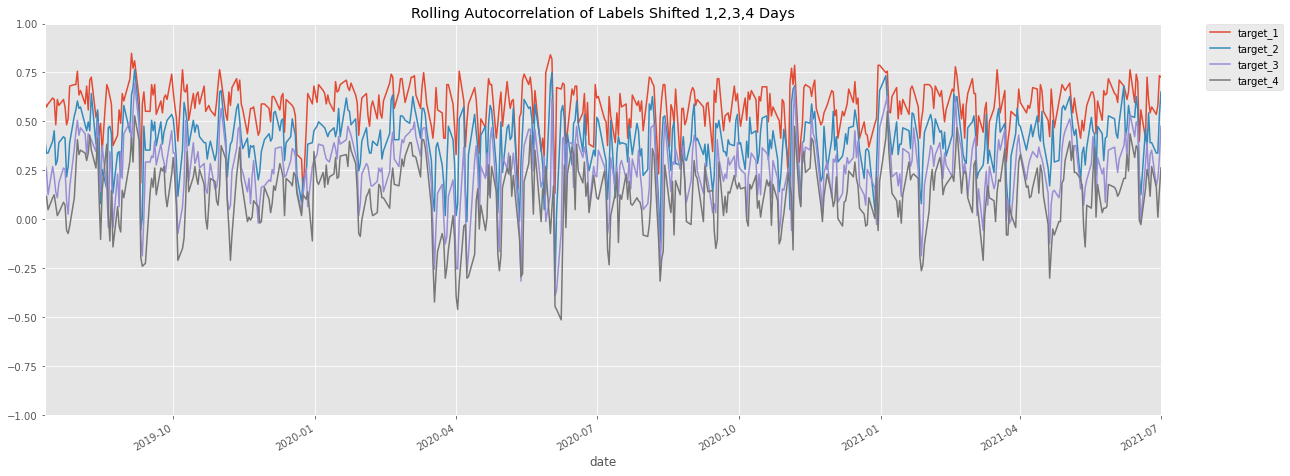

In [58]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_1'] = all_factors.groupby(level='ticker')[target_source].shift(-4)
all_factors['target_2'] = all_factors.groupby(level='ticker')[target_source].shift(-3)
all_factors['target_3'] = all_factors.groupby(level='ticker')[target_source].shift(-2)
all_factors['target_4'] = all_factors.groupby(level='ticker')[target_source].shift(-1)

g = all_factors.dropna().groupby(level='date')
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

## Evaluate Autocorrelation IID Results

As you can see, the further out from the target (target_4) we are the less correlated the data is.

In [59]:
all_factors.columns.values

array(['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end',
       '5Day2Quant', 'target', 'target_1', 'target_2', 'target_3',
       'target_4'], dtype=object)

In [60]:
features = ['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end']

target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

X_train.head()

1.0


momentum_252_day_logret  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.549913   
                          AAL                   -1.103119   
                          AAP                    0.227210   
                          AAPL                   0.009879   
                          ABBV                  -1.366551   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-10 00:00:00+00:00 A                                  -1.346793   
                          AAL                                -0.694800   
                          AAP                                 0.418197   
                          AAPL                               -1.057019   
                          ABBV                                1.379722   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-10 00:00:00+00:00 A                                 0.233794   
                          AAL                               0.767241   
                          AAP                              -0.602597   
                          AAPL                             -0.075736   
                          ABBV                             -0.628940   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-10 00:00:00+00:00 A                          0.866031   
                          AAL                        1.122877   
                          AAP                        0.411612   
                          AAPL                       0.734315   
                          ABBV                       0.905546   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.714558   
                          AAL                         0.457712   
                          AAP                        -0.754073   
                          AAPL                        1.406065   
                          ABBV                       -1.089948   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.075737   
                          AAL                         0.431369   
                          AAP                         0.075737   
                          AAPL                        1.722183   
                          ABBV                        1.603639   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-10 00:00:00+00:00 A                            0.082322   
                          AAL                          0.576256   
                          AAP                          0.332582   
                          AAPL                         1.722183   
                          ABBV                         1.399480   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.013883   
                          AAL                    0.013883   
                          AAP                    0.013883   
                          AAPL                   0.013883   
                          ABBV                   0.013883   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-10 00:00:00+00:00 A                       0.016321   
                          AAL                     0.016321   
                          AAP                     0.01

## Build and Train a model to derive our AI generated Alpha
### Build an ensemble of non-overlapping trees
Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [61]:
import abc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

print(f'Sci-Kit version: {sklearn.__version__}')


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        self.estimator = estimator
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        self.feature_importances_ = self.feature_importances(self.estimators_)
        
        return self
    
class NoOverlapVoter(NoOverlapVoterAbstract):
            
    def _calculate_oob_score(self, classifiers):
        oob_scores = []
        for classifier in classifiers:
            oob_scores.append(classifier.oob_score_)

        return np.mean(oob_scores)
    
    def feature_importances(self, classifiers):
        feature_importances = []
        for classifier in classifiers:
            feature_importances.append(classifier.feature_importances_)
            
        return np.mean(feature_importances, axis=0)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        fit_classifiers = []
        for clf_idx in range(len(classifiers)):
            x_samp, y_samp = utils.non_overlapping_samples(x, y, n_skip_samples, clf_idx)
            fit_classifiers.append(classifiers[clf_idx].fit(x_samp, y_samp))

        return fit_classifiers

Sci-Kit version: 0.24.1


#### Train Model

In [62]:
n_days = 8
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 1000]

Training Models:   0%|          | 0/4 [00:00<?, ?Model/s]

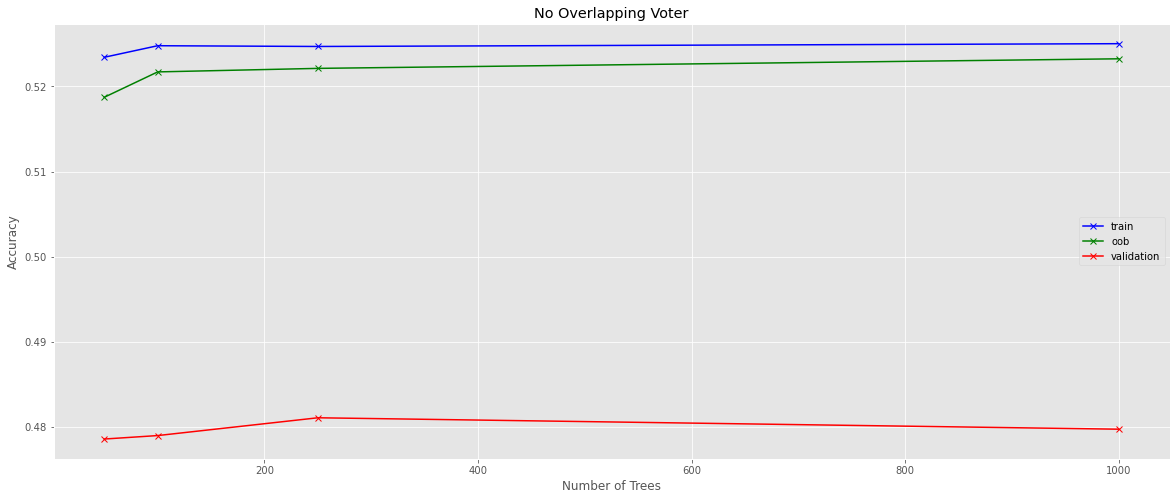

In [63]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)
    
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'No Overlapping Voter', 'Number of Trees')

In [54]:
factor_names = [
     'mean_reversion_5_day_logret_smoothed',
     'momentum_252_day_logret',
     'overnight_sentiment_5_day_smoothed',
     'average_dollar_volume_120_day',
     'annualzed_volatility_20_day'
]

In [64]:
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)

      Feature                                  Importance
 1. momentum_252_day_logret              (0.23899570771174172)
 2. overnight_sentiment_5_day_smoothed   (0.21792245473589505)
 3. annualzed_volatility_20_day          (0.09411170632670385)
 4. annualzed_volatility_120_day         (0.07207278791165188)
 5. market_volatility120_day             (0.06792567773591837)
 6. average_dollar_volume_120_day        (0.06534215966668618)
 7. average_dollar_volume_20_day         (0.05996460298346003)
 8. mean_reversion_5_day_logret_smoothed (0.05471034584395238)
 9. market_dispersion120_day             (0.031046539519220102)
10. market_volatility20_day              (0.03025336079501762)
11. market_dispersion20_day              (0.02664404169144659)
12. weekday                              (0.01792855205172759)
13. quarter                              (0.012501722255940168)
14. year                                 (0.010580340770638453)
15. quarter_start                        (0.0)
16. is_Jan

['momentum_252_day_logret']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


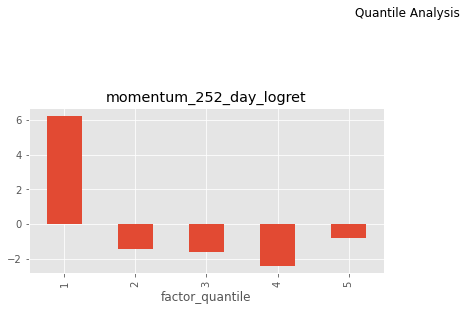

['overnight_sentiment_5_day_smoothed']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


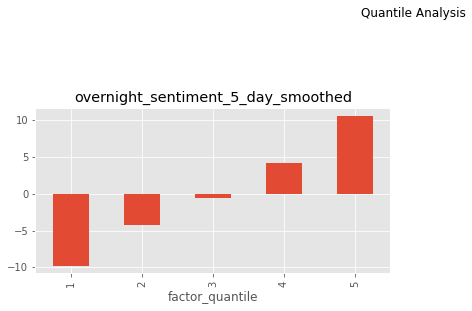

['annualzed_volatility_20_day']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


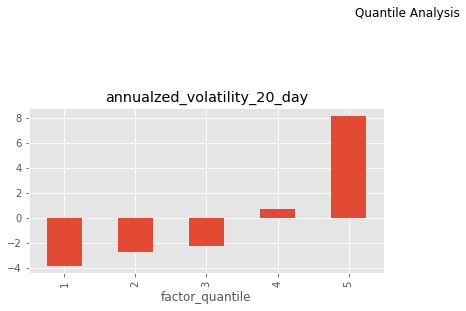

['annualzed_volatility_120_day']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


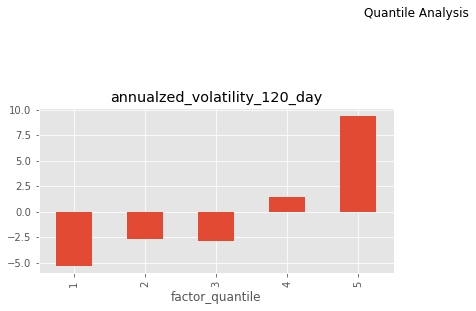

['market_volatility120_day']
Dropped 100.0% entries from factor data: 0.0% in forward returns computation and 100.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['average_dollar_volume_120_day']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


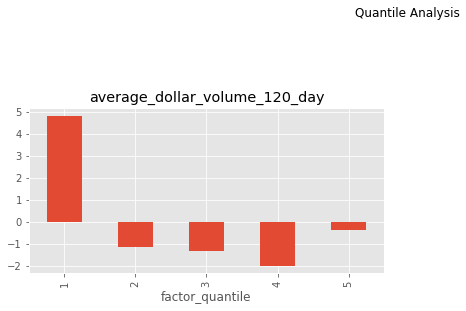

['average_dollar_volume_20_day']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


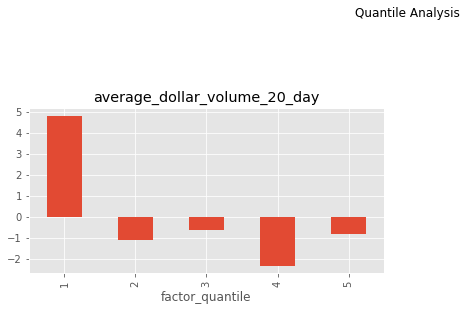

['mean_reversion_5_day_logret_smoothed']
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


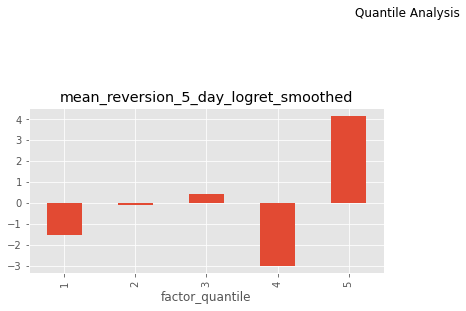

['market_dispersion120_day']
Dropped 100.0% entries from factor data: 0.0% in forward returns computation and 100.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data


In [49]:
batch_size = 1
for i in range(0,9,batch_size):
    features_to_use = ranked_features[i:i+batch_size]
    print(features_to_use)
    try:
        clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors[features_to_use], pricing)
        alpha_factors.plot_basis_points_per_day_quantile(unixt_factor_data)
        plt.show()
    except:
        print('Issue getting clean factor data')


In [65]:
factor_names = ['overnight_sentiment_5_day_smoothed', 'annualzed_volatility_20_day', 'annualzed_volatility_120_day']

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.54
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

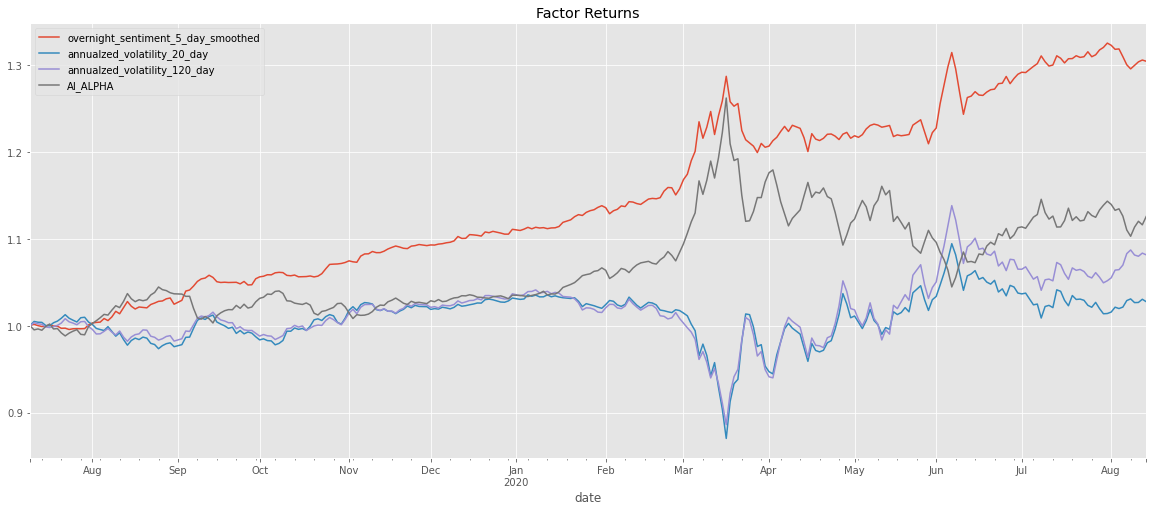

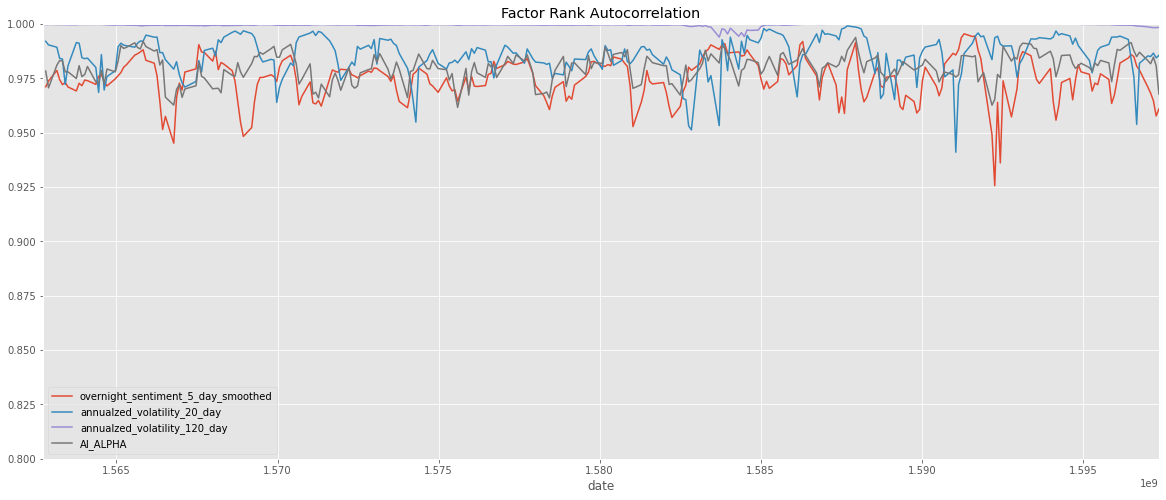

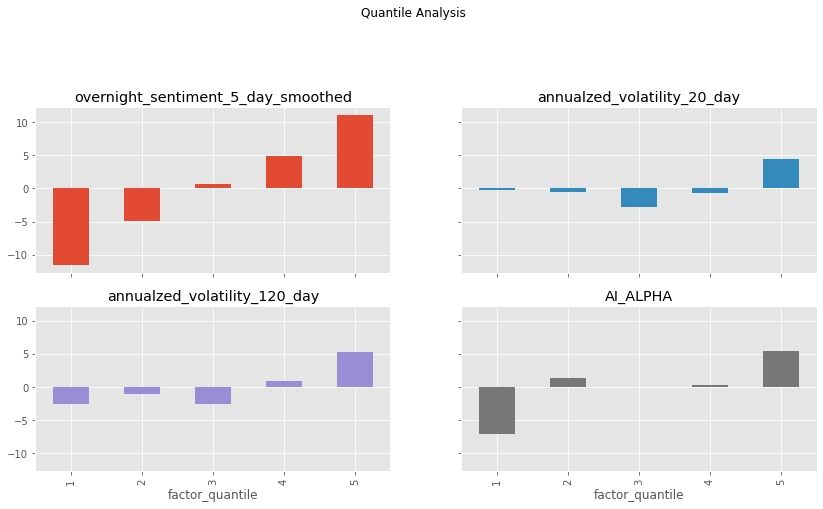

In [66]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, factor_names, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.20
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

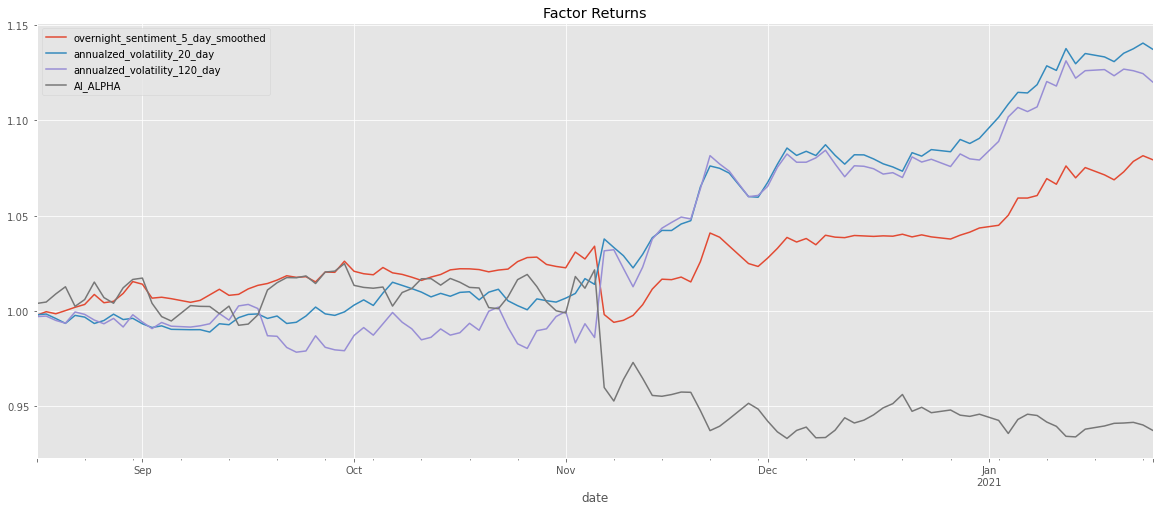

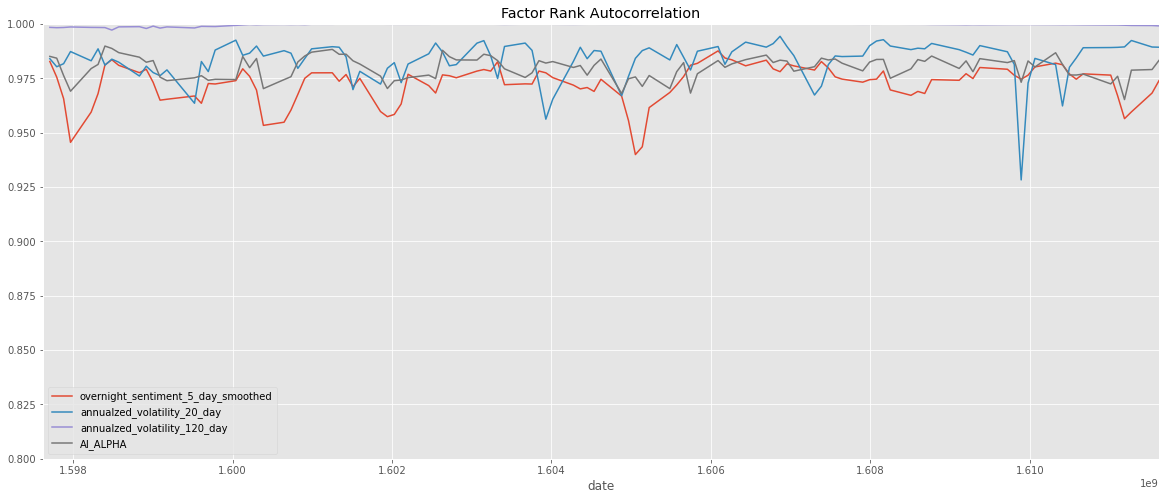

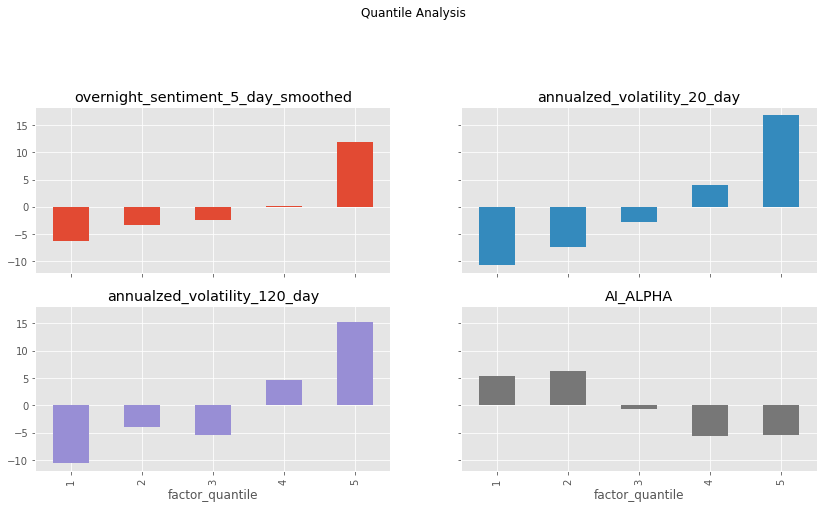

In [67]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, factor_names, pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [17]:
print('Features Ranked by Average Importance:\n')
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)
ranked_features

Features Ranked by Average Importance:

      Feature                                  Importance
 1. momentum_252_day_logret              (0.23899570771174172)
 2. overnight_sentiment_5_day_smoothed   (0.21792245473589505)
 3. annualzed_volatility_20_day          (0.09411170632670385)
 4. annualzed_volatility_120_day         (0.07207278791165188)
 5. market_volatility120_day             (0.06792567773591837)
 6. average_dollar_volume_120_day        (0.06534215966668618)
 7. average_dollar_volume_20_day         (0.05996460298346003)
 8. mean_reversion_5_day_logret_smoothed (0.05471034584395238)
 9. market_dispersion120_day             (0.031046539519220102)
10. market_volatility20_day              (0.03025336079501762)
11. market_dispersion20_day              (0.02664404169144659)
12. weekday                              (0.01792855205172759)
13. quarter                              (0.012501722255940168)
14. year                                 (0.010580340770638453)
15. quarter_start

['momentum_252_day_logret',
 'overnight_sentiment_5_day_smoothed',
 'annualzed_volatility_20_day',
 'annualzed_volatility_120_day',
 'market_volatility120_day',
 'average_dollar_volume_120_day',
 'average_dollar_volume_20_day',
 'mean_reversion_5_day_logret_smoothed',
 'market_dispersion120_day',
 'market_volatility20_day',
 'market_dispersion20_day',
 'weekday',
 'quarter',
 'year',
 'quarter_start',
 'is_January',
 'is_December',
 'month_start',
 'month_end',
 'quarter_end']

In [68]:
features_to_use = factor_names
print(features_to_use)

['overnight_sentiment_5_day_smoothed', 'annualzed_volatility_20_day', 'annualzed_volatility_120_day']


In [69]:
prod_target_source = '5Day5Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 5, 5).for_al(prod_target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[prod_target_source].shift(-forward_prediciton_days)
all_factors[[prod_target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.549913   
                          AAL                   -1.103119   
                          AAP                    0.227210   
                          AAPL                   0.009879   
                          ABBV                  -1.366551   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-10 00:00:00+00:00 A                                  -1.346793   
                          AAL                                -0.694800   
                          AAP                                 0.418197   
                          AAPL                               -1.057019   
                          ABBV                                1.379722   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-10 00:00:00+00:00 A                                 0.233794   
                          AAL                               0.767241   
                          AAP                              -0.602597   
                          AAPL                             -0.075736   
                          ABBV                             -0.628940   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-10 00:00:00+00:00 A                          0.866031   
                          AAL                        1.122877   
                          AAP                        0.411612   
                          AAPL                       0.734315   
                          ABBV                       0.905546   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.714558   
                          AAL                         0.457712   
                          AAP                        -0.754073   
                          AAPL                        1.406065   
                          ABBV                       -1.089948   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-10 00:00:00+00:00 A                          -0.075737   
                          AAL                         0.431369   
                          AAP                         0.075737   
                          AAPL                        1.722183   
                          ABBV                        1.603639   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-10 00:00:00+00:00 A                            0.082322   
                          AAL                          0.576256   
                          AAP                          0.332582   
                          AAPL                         1.722183   
                          ABBV                         1.399480   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-10 00:00:00+00:00 A                      0.013883   
                          AAL                    0.013883   
                          AAP                    0.013883   
                          AAPL                   0.013883   
                          ABBV                   0.013883   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-10 00:00:00+00:00 A                       0.016321   
                          AAL                     0.016321   
                          AAP                     0.01

,date,ticker,5Day5Quant,target
0,2019-07-10 00:00:00+00:00,A,0,0.0
526,2019-07-11 00:00:00+00:00,A,0,0.0
1052,2019-07-12 00:00:00+00:00,A,0,0.0
1578,2019-07-15 00:00:00+00:00,A,0,1.0
2104,2019-07-16 00:00:00+00:00,A,0,2.0
2630,2019-07-17 00:00:00+00:00,A,0,1.0
3156,2019-07-18 00:00:00+00:00,A,0,2.0
3682,2019-07-19 00:00:00+00:00,A,0,2.0
4208,2019-07-22 00:00:00+00:00,A,1,3.0
4734,2019-07-23 00:00:00+00:00,A,2,2.0


In [70]:
temp = all_factors.dropna().copy()
X = temp[features_to_use]
y = temp['target']

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

1.0


In [71]:
clf = RandomForestClassifier(2000, **clf_parameters)

clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X, y)

NoOverlapVoter(estimator=RandomForestClassifier(criterion='entropy',
                                                min_samples_leaf=4208,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True,
                                                random_state=42))

### Results
#### Accuracy

In [72]:
print('train: {}, oob: {}, valid: {}, test:{}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.score(X_test, y_test.values),
    clf_nov.oob_score_))

train: 0.23505321831091486, oob: 0.24293862031504618, valid: 0.24287072243346008, test:0.23683220033029917


#### Train

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.54
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

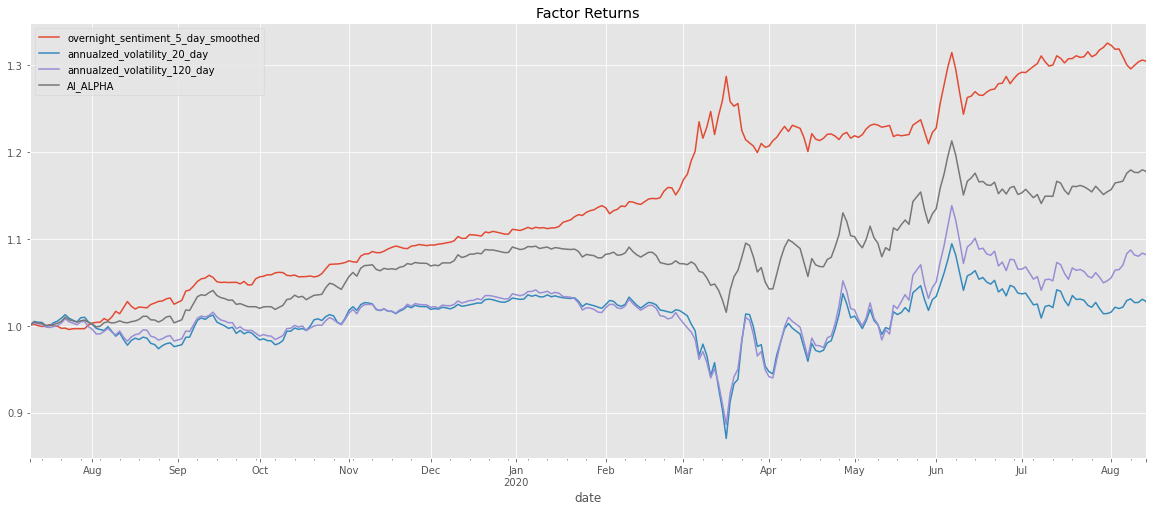

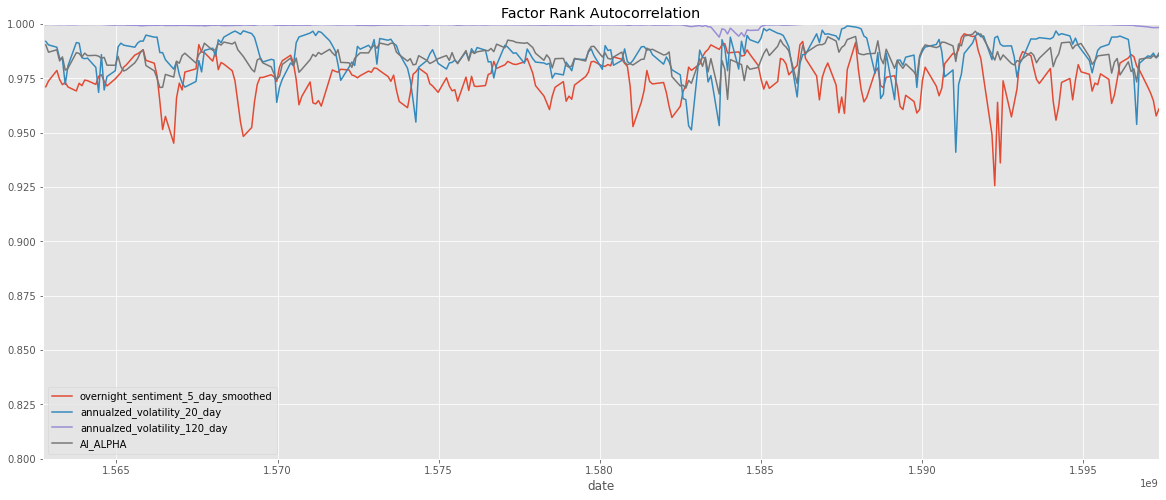

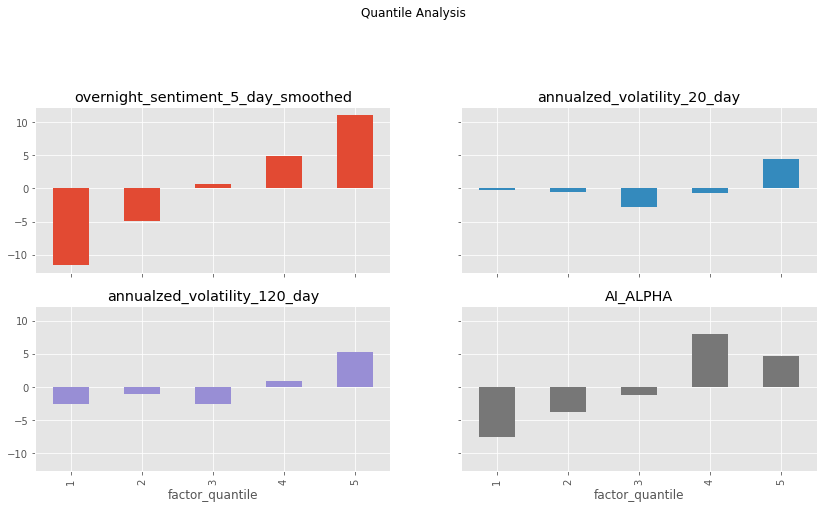

In [73]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, features_to_use, pricing)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.20
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

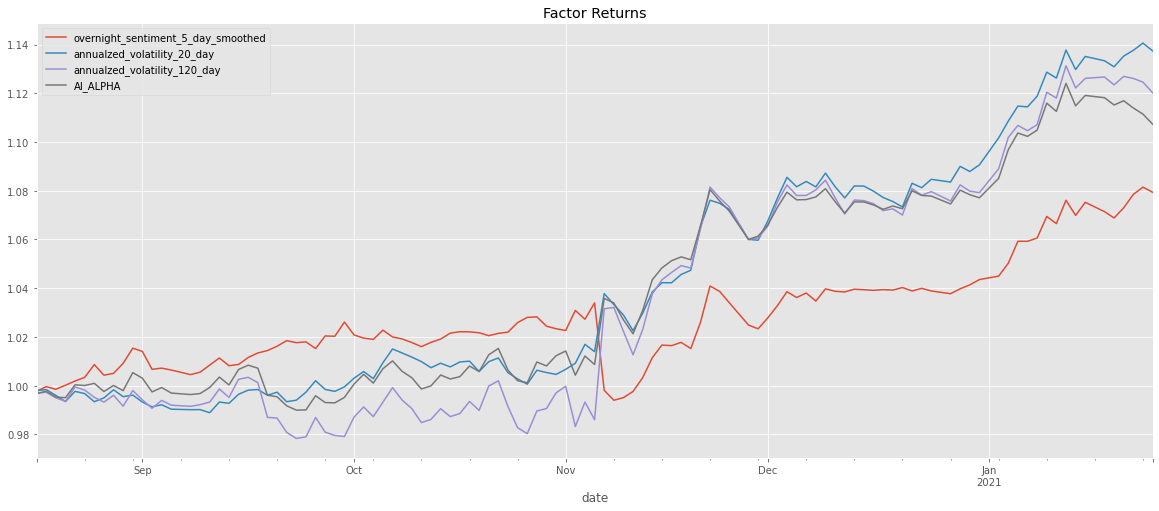

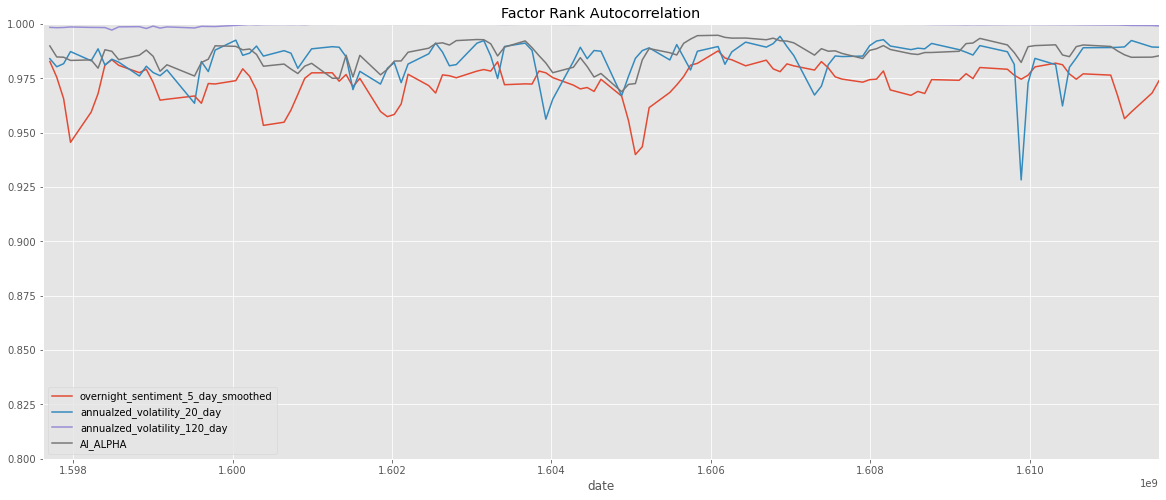

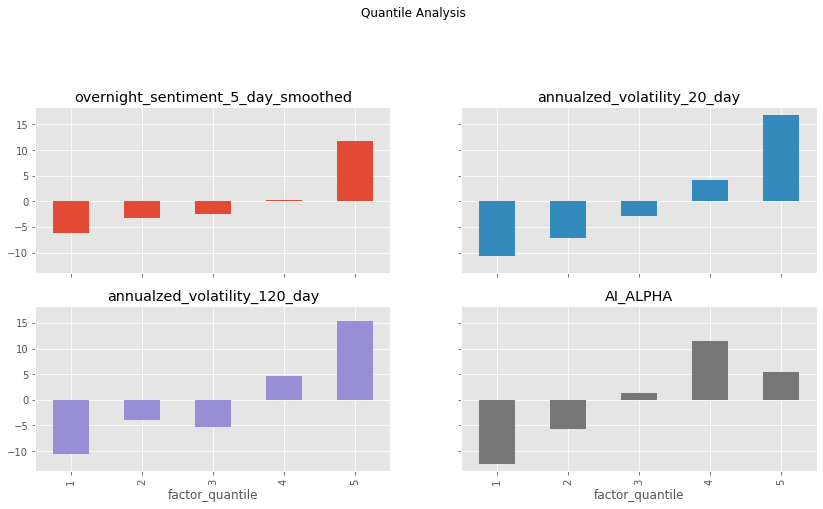

In [74]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, features_to_use, pricing)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          3.10
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

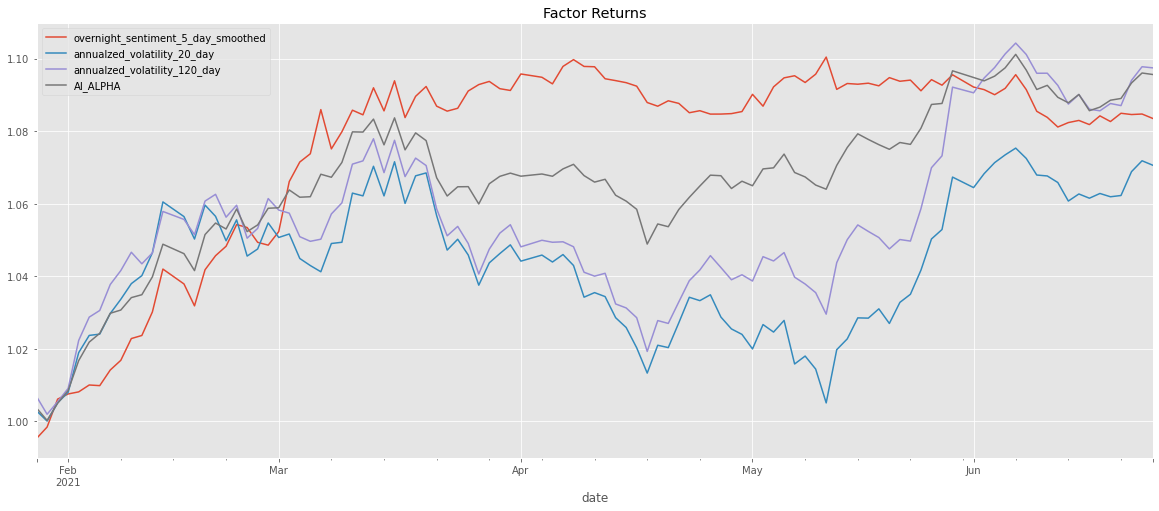

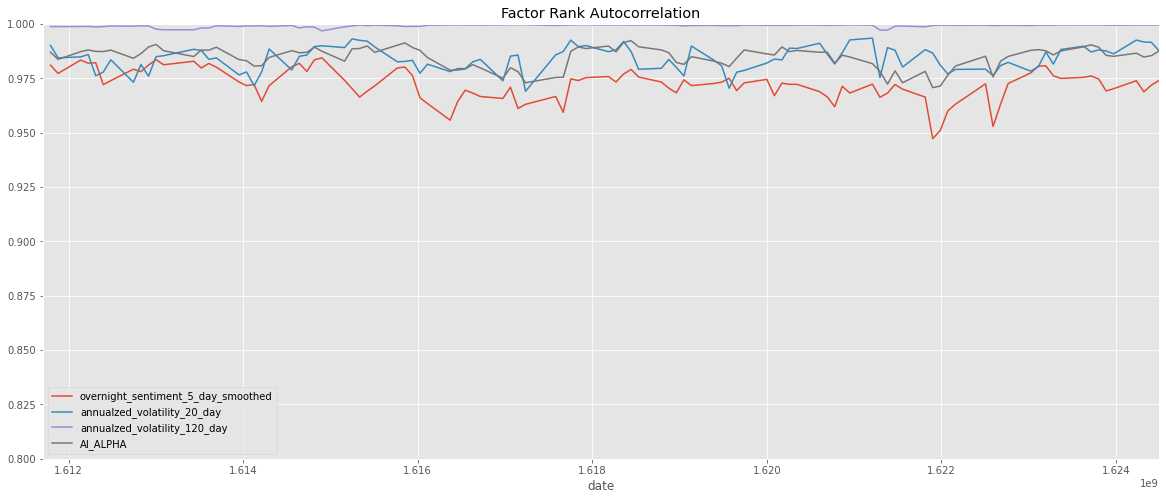

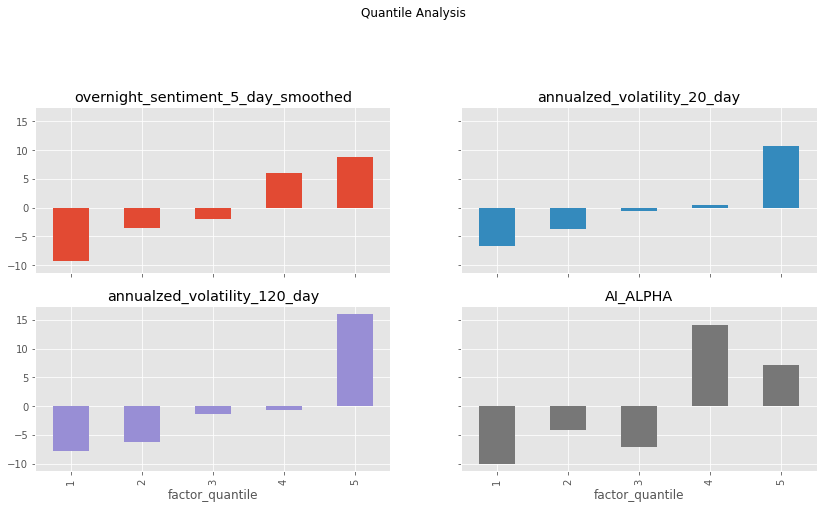

In [75]:
alpha_factors.evaluate_ai_alpha(all_factors, X_test, clf_nov, features_to_use, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.53
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

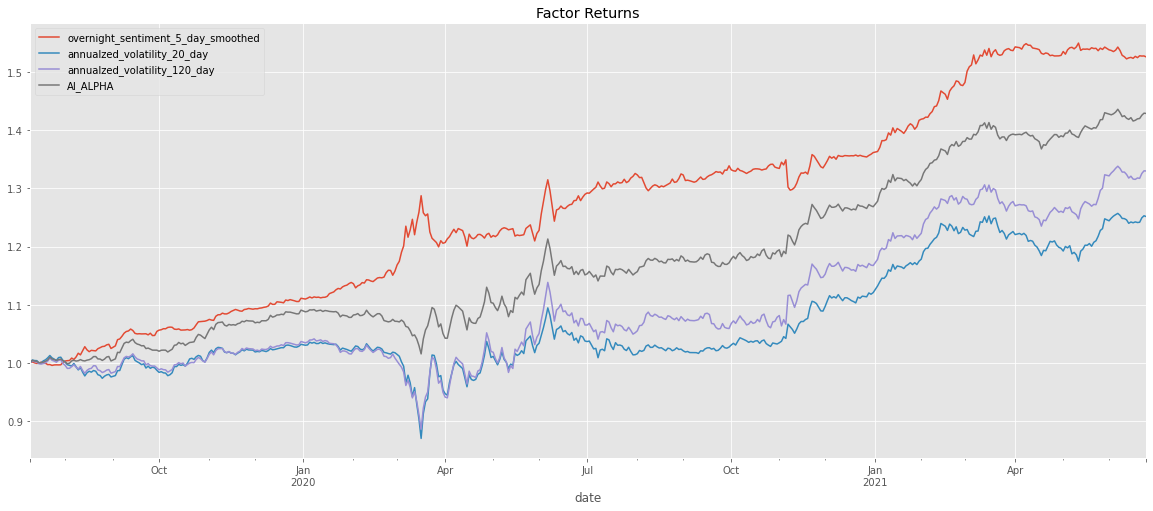

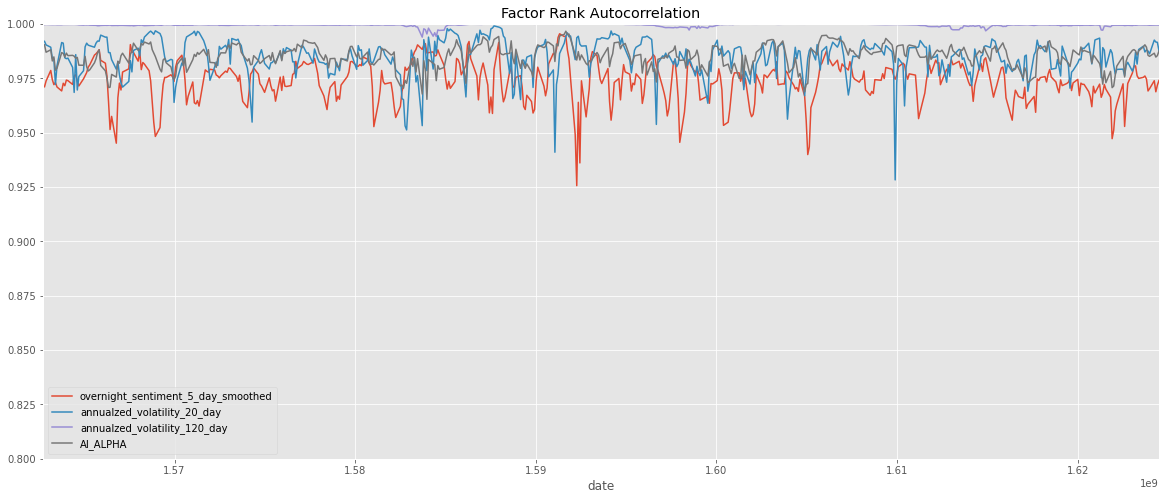

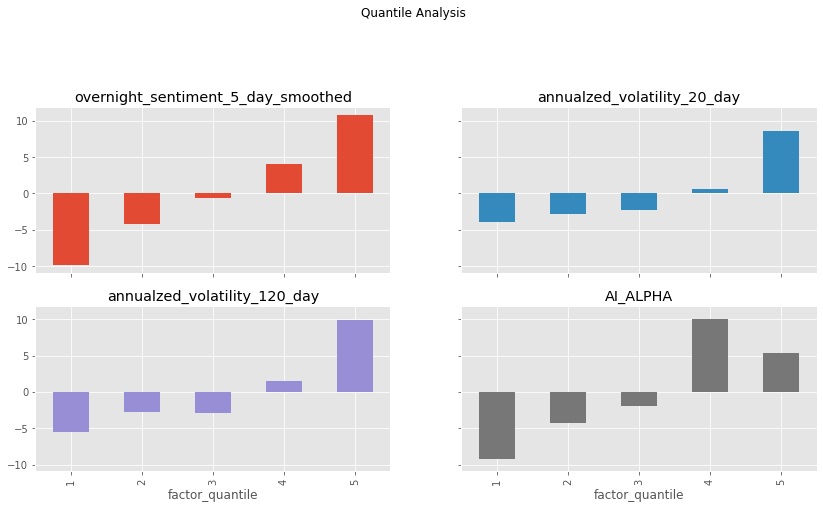

In [84]:
ai_alpha = alpha_factors.evaluate_ai_alpha(all_factors, X, clf_nov, features_to_use, pricing)

In [94]:
X

overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-10 00:00:00+00:00 A                                 0.233794   
                          AAL                               0.767241   
                          AAP                              -0.602597   
                          AAPL                             -0.075736   
                          ABBV                             -0.628940   
...                                                              ...   
2021-06-24 00:00:00+00:00 XLNX                              0.154765   
                          XOM                               1.050428   
                          XRAY                             -0.648697   
                          XYL                               0.464296   
                          ZKIN                              1.649732   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-10 00:00:00+00:00 A                          0.866031   
                          AAL                        1.122877   
                          AAP                        0.411612   
                          AAPL                       0.734315   
                          ABBV                       0.905546   
...                                                       ...   
2021-06-24 00:00:00+00:00 XLNX                       0.543325   
                          XOM                       -0.115251   
                          XRAY                      -1.175558   
                          XYL                       -0.977985   
                          ZKIN                       1.636560   

                                  annualzed_volatility_120_day  
date                      ticker                                
2019-07-10 00:00:00+00:00 A                          -0.714558  
                          AAL                         0.457712  
                          AAP                        -0.754073  
                          AAPL                        1.406065  
                          ABBV                       -1.089948  
...                                                        ...  
2021-06-24 00:00:00+00:00 XLNX                        1.412645  
                          XOM                         1.425816  
                          XRAY                       -0.918713  
                          XYL                        -1.201901  
                          ZKIN                        1.676075  

[260370 rows x 3 columns]

## Model evaluation

This looks like a pretty good model. Let's generate the alpha vectors for each day and save them

In [96]:
alpha_vectors = ai_alpha.to_frame().unstack('asset')
alpha_vectors.to_csv('data/alpha_vectors.csv')

## TODO:

- Store Model (This might not be necessary. If the model is to be retrained on the same parameters, then we might just need them. this is for the production AI)
- Store Model parameters
- Store features to use

# Stopped here

# TODO

- Use AI Alpha from top factors
- Get daily Alpha/Beta/Idiosyncratic...
- Compute optimization parameters
- Init holdings
- Run Backtests
- Generate Portfolio

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [27]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.12, weights_min=-0.12).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

NameError: name 'OptimalHoldings' is not defined

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)